In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Load all the required libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score
from collections import Counter

plt.rc('figure',figsize=(18,9))
%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

Note: you may need to restart the kernel to use updated packages.


## Load the dataset

In [3]:
credit_data = pd.read_csv('/Users/lacy/Documents/Advanced business analy/BankChurners.csv')
credit_data = credit_data[credit_data.columns[:-2]]
credit_data.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000


In [4]:
X = credit_data.drop('Attrition_Flag', axis=1)
y = credit_data['Attrition_Flag']

## Exploratory Data Analysis

1. **Age distribution**

<AxesSubplot:title={'center':'Age with Churned or not'}, xlabel='Customer_Age', ylabel='count'>

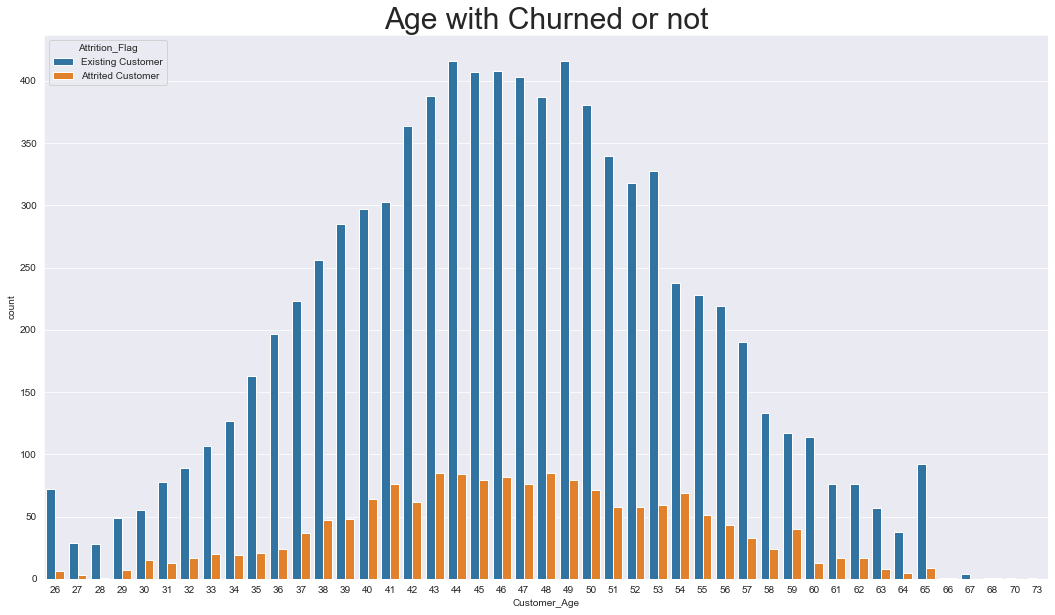

In [5]:
plt.figure(figsize = (18,10))
plt.title("Age with Churned or not", fontsize = 30)
sns.countplot(data = credit_data, x = credit_data["Customer_Age"], hue = "Attrition_Flag")

We can see that the distribution of customer ages in our dataset follows a fairly normal distribution, thus further use of the age feature can be done with the normality assumption.

**2. Percentage of existing and attrited customers**

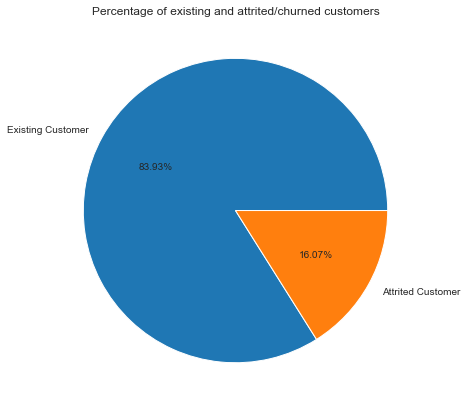

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
count = Counter(y)
ax.pie(count.values(), labels=count.keys(), autopct=lambda p:f'{p:.2f}%')
ax.set_title('Percentage of existing and attrited/churned customers')
plt.show()

As we can see only 16% of the data samples represent churn customers, so we will use SMOTE to upsample the churn samples to match them with the regular customer sample size in order to give the later selected models a better chance of catching on small details which will almost definitely be missed out with such a size difference.

**3. Gender wise Existing and Churned customers**

<AxesSubplot:title={'center':'Gender wise Existing and Churned customers'}, xlabel='Gender', ylabel='count'>

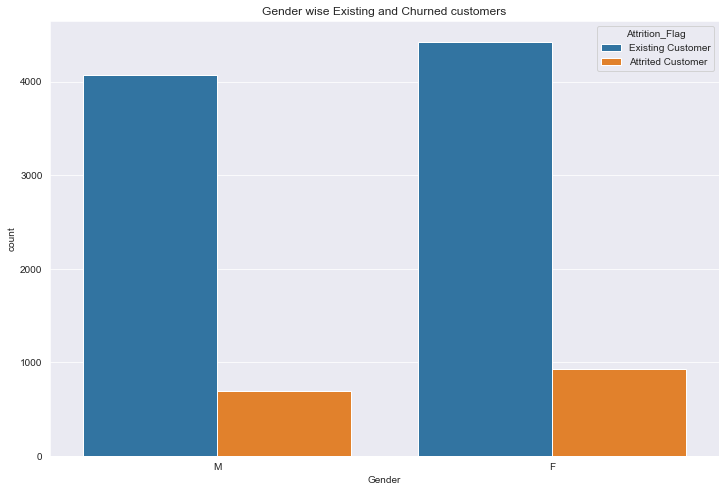

In [7]:
#countplot
plt.figure(figsize = (12,8))
plt.title("Gender wise Existing and Churned customers")
sns.countplot(data = credit_data, x = credit_data["Gender"], hue = "Attrition_Flag")

**4. Education Level in Existing and Churned Customers**

([<matplotlib.patches.Wedge at 0x7f9338566a00>,
 [Text(0.6162726886888835, 0.9111574908742038, "('Graduate',)"),
  Text(-0.9328768014299642, 0.5828729478658272, "('High School',)"),
  Text(-0.9439062217682513, -0.564837184069166, "('Unknown',)"),
  Text(-0.11282467086602758, -1.0941986079519443, "('Uneducated',)"),
  Text(0.688876872023183, -0.8575830310771986, "('College',)"),
  Text(1.0044585550129046, -0.4484005031903824, "('Doctorate',)"),
  Text(1.0904918109277202, -0.14431774076523463, "('Post-Graduate',)")],
 [Text(0.3361487392848455, 0.49699499502229294, '31.07%'),
  Text(-0.5088418916890713, 0.3179306988359057, '20.08%'),
  Text(-0.5148579391463188, -0.30809300949227236, '14.86%'),
  Text(-0.061540729563287766, -0.5968356043374241, '14.71%'),
  Text(0.37575102110355435, -0.4677725624057446, '10.11%'),
  Text(0.5478864845524933, -0.24458209264929945, '4.99%'),
  Text(0.5948137150514836, -0.07871876769012798, '4.19%')])

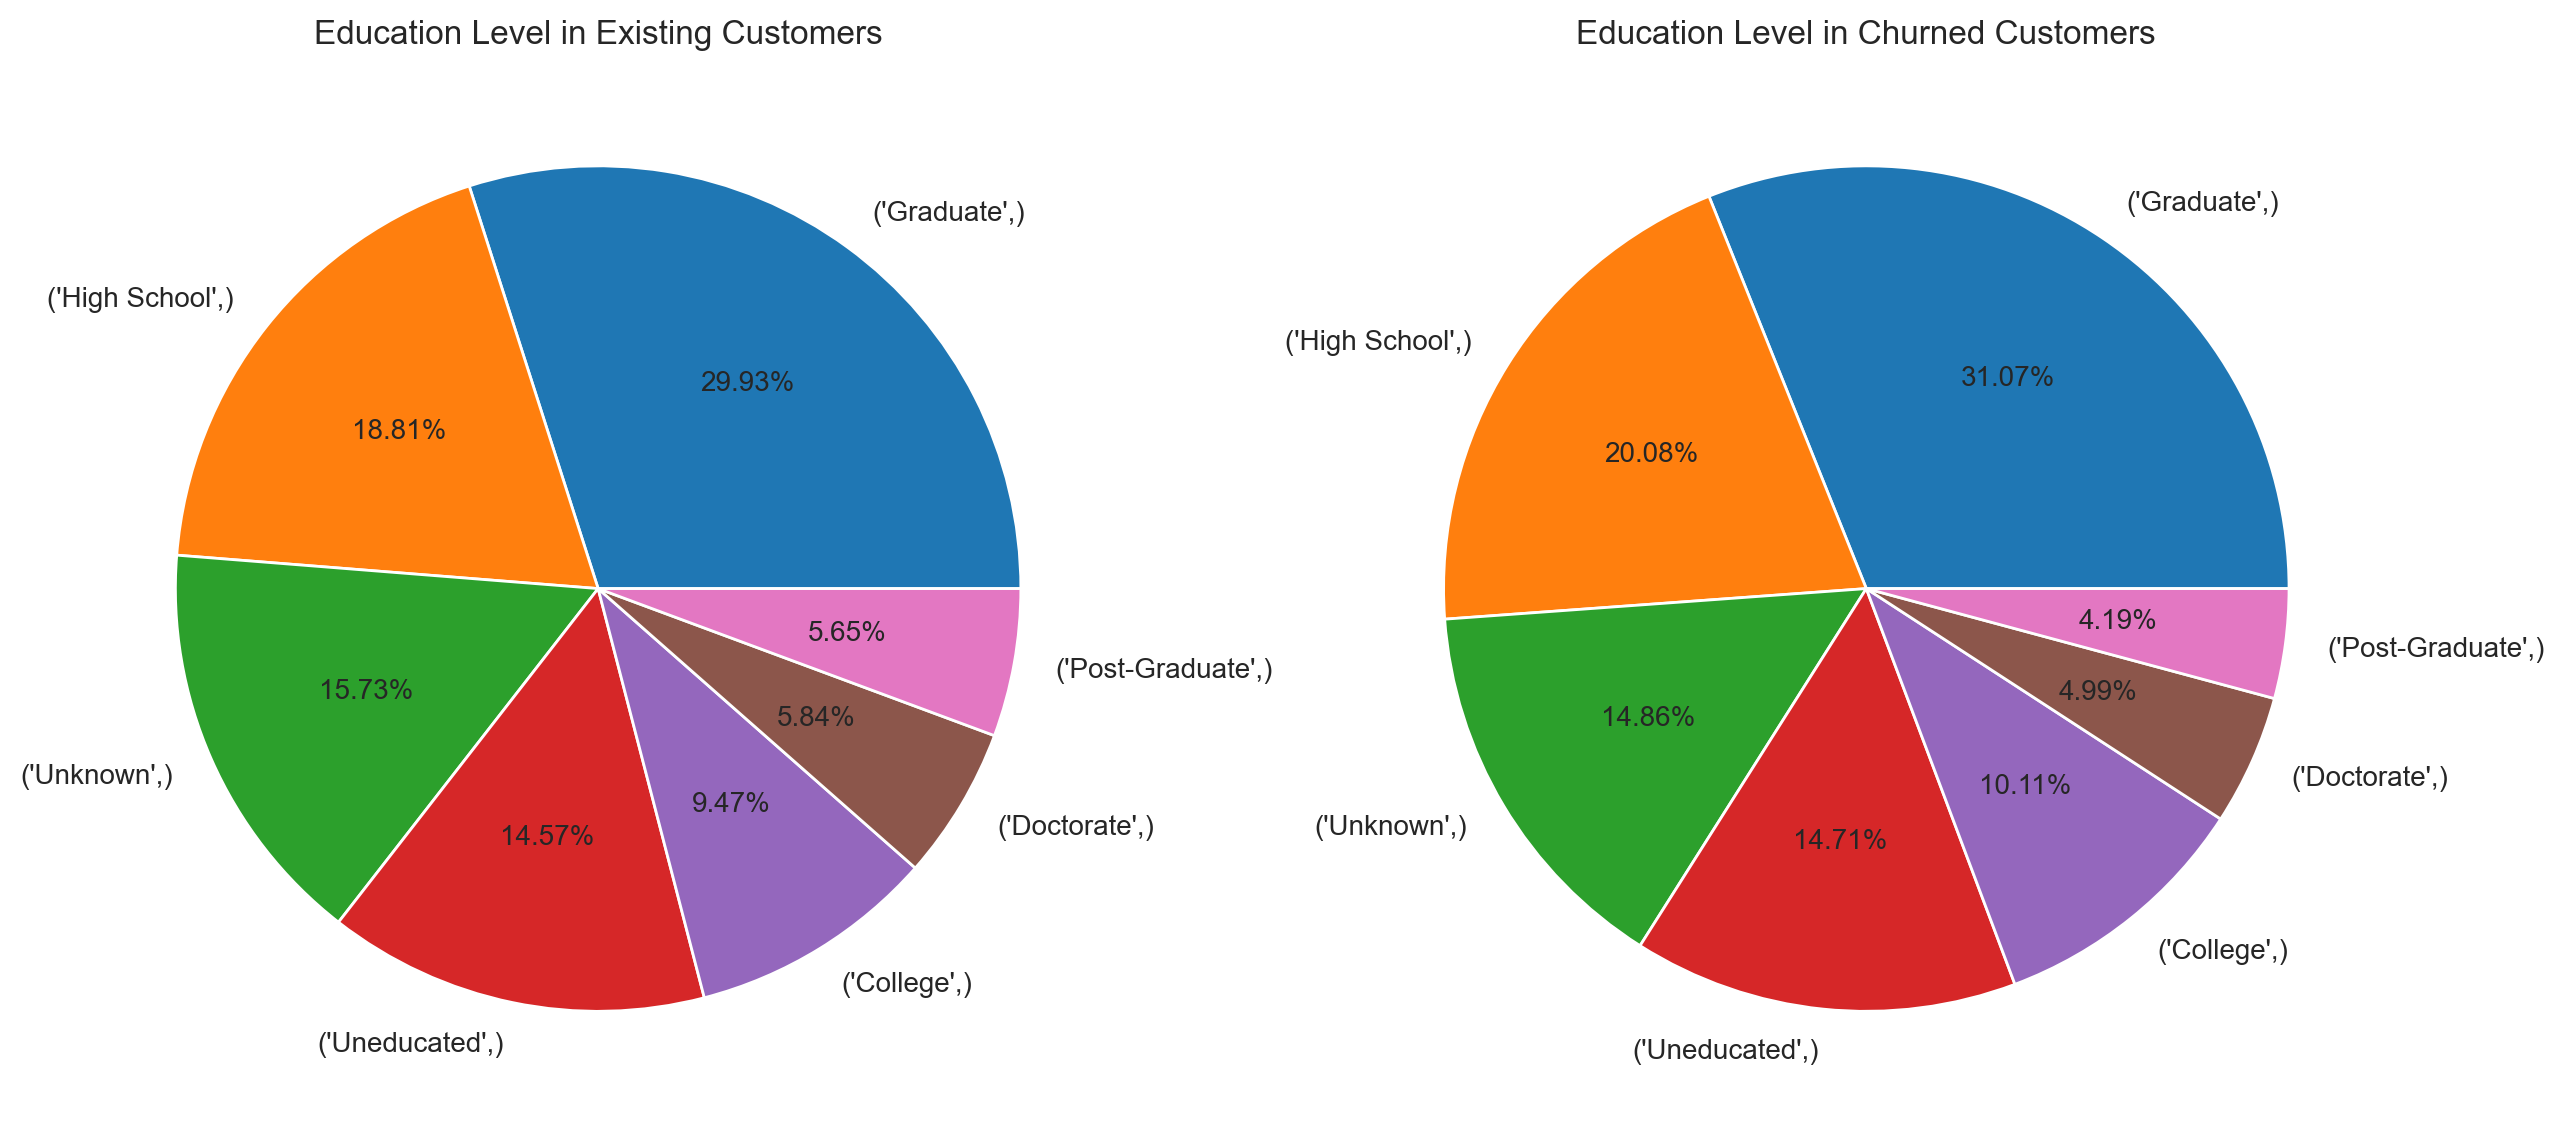

In [8]:
gender = credit_data.loc[credit_data["Attrition_Flag"] == "Attrited Customer", ["Education_Level"]].value_counts()
gender_normal = credit_data.loc[credit_data["Attrition_Flag"] == "Attrited Customer", ["Education_Level"]].value_counts().tolist()
gender_churned = credit_data.loc[credit_data["Attrition_Flag"] == "Existing Customer", ["Education_Level"]].value_counts().tolist()
fig, ax = plt.subplots(1, 2, dpi = 200, figsize = (15,8))
ax[0].set_title("Education Level in Existing Customers")
ax[0].pie(x = gender_normal, labels = gender.index, autopct='%.2f%%')
ax[1].set_title("Education Level in Churned Customers")
ax[1].pie(x = gender_churned, labels = gender.index, autopct='%.2f%%')

The features in our dataset have some correlation, for example, Months_on_book and Customer_age, Avg_Utilization_Ratio and Total_Revolving_Bal.

## DATA PROCESSING


Convert all the categorical variables into numerical variable

In [10]:
# #--------------let's convert some categorical variables into numerical--------------

# #ordinal to numerical
map_education_level = {'High School':1,'Graduate':3,'Uneducated':0,'College':2,'Post-Graduate':4,'Doctorate':5}
map_income_level = {'$60K - $80K':3,'Less than $40K':1, '$80K - $120K':4,'$40K - $60K':2,'$120K +':5}
map_card_category = {'Blue':1,'Gold':3,'Silver':2,'Platinum':4}
X['Education_Level'].replace(map_education_level,inplace=True)
X['Income_Category'].replace(map_income_level,inplace=True)
X['Card_Category'].replace(map_card_category,inplace=True)


# #hot encoding of gender category
X.insert(2,'Gender_M',X['Gender'],True)
X.rename({'Gender':'Gender_F'},axis=1,inplace=True)
X['Gender_M'].replace({'M':1,'F':0},inplace=True)
X['Gender_F'].replace({'M':0,'F':1},inplace=True)


# #hot encoding of marital status
X.insert(7,'Single',X['Marital_Status'],True)
X.insert(7,'Divorced',X['Marital_Status'],True)
X.insert(7,'Unknown',X['Marital_Status'],True)
X.rename({'Marital_Status':'Married'},axis=1,inplace=True)
X['Married'].replace({'Single':0, 'Married':1, 'Divorced':0, 'Unknown':0},inplace=True)
X['Single'].replace({'Single':1, 'Married':0, 'Divorced':0, 'Unknown':0},inplace=True)
X['Divorced'].replace({'Single':0, 'Married':0, 'Divorced':1, 'Unknown':0},inplace=True)
X['Unknown'].replace({'Single':0, 'Married':0, 'Divorced':0, 'Unknown':1},inplace=True)


y.replace({'Existing Customer':0, 'Attrited Customer':1},inplace=True)

X.head()

,CLIENTNUM,Customer_Age,Gender_M,Gender_F,Dependent_count,Education_Level,Married,Unknown,Divorced,Single,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,45,1,0,3,1,1,0,0,0,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,49,0,1,5,3,0,0,0,1,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,51,1,0,3,3,1,0,0,0,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,40,0,1,4,1,0,1,0,0,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,40,1,0,3,0,1,0,0,0,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Handling missing values

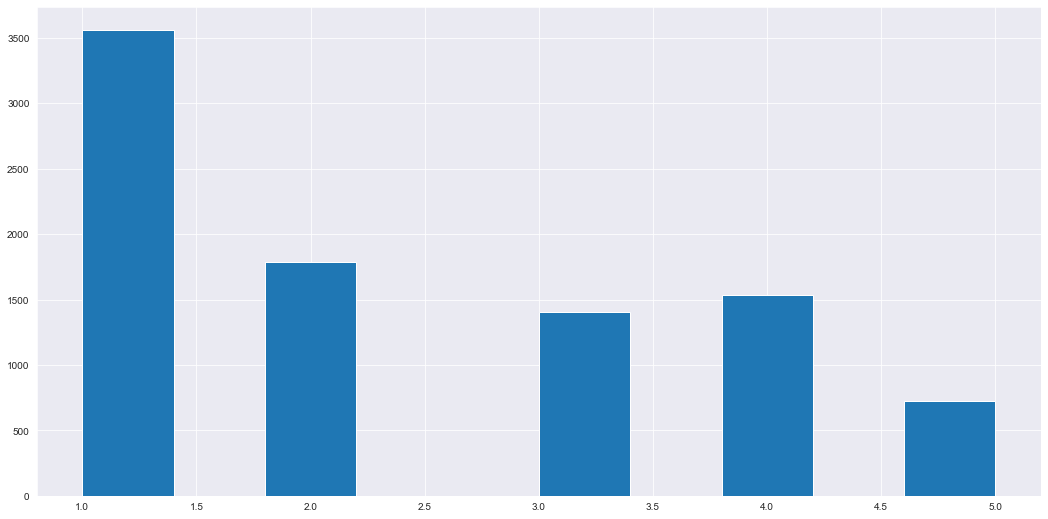

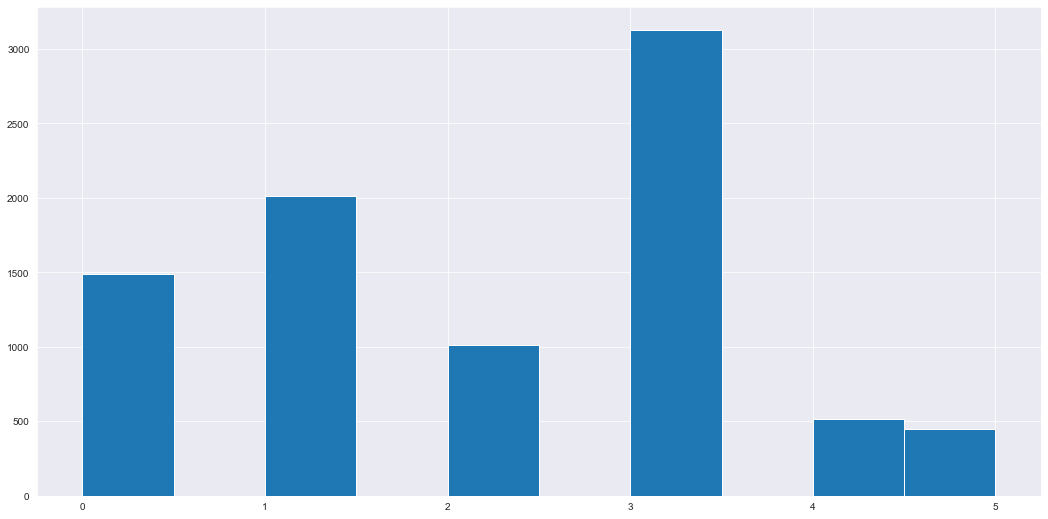

,CLIENTNUM,Customer_Age,Gender_M,Gender_F,Dependent_count,Education_Level,Married,Unknown,Divorced,Single,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,45,1,0,3,1.0,1,0,0,0,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,49,0,1,5,3.0,0,0,0,1,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,51,1,0,3,3.0,1,0,0,0,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,40,0,1,4,1.0,0,1,0,0,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,40,1,0,3,0.0,1,0,0,0,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [11]:
plt.hist(X.loc[X['Income_Category']!='Unknown']['Income_Category'])   # income is rightly skewed. so central value is median
plt.show()

plt.hist(X.loc[X['Education_Level']!='Unknown']['Education_Level'])   # education is normally distributed. so central value is mean
plt.show()

#Missing values in education column
educatedDF = X.loc[X['Education_Level']!='Unknown']
mean_education = educatedDF['Education_Level'].mean()
X['Education_Level'].replace({'Unknown':mean_education},inplace=True)

#Missing values in income column
salariedDF = X.loc[X['Income_Category']!='Unknown']
median_salaries = salariedDF['Income_Category'].median()
X['Income_Category'].replace({'Unknown':median_salaries},inplace=True)

X.head()

## Data Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

## Upsampling using SMOTE

In [13]:
#-----Upsampling----
from sklearn.utils import resample
from collections import Counter

print("Before Upsampling:-")
print(Counter(y_train))


# Let's use SMOTE to oversample
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_upsampled, y_train_upsampled = oversample.fit_resample(X_train,y_train)

print("After Upsampling:-")
print(Counter(y_train_upsampled))

Before Upsampling:-
Counter({0: 5699, 1: 1086})
After Upsampling:-
Counter({0: 5699, 1: 5699})


## Building Classification models


1. Random Forest

In [14]:
classifier = RandomForestClassifier(n_estimators = 50, random_state = 0)
classifier.fit(X_train_upsampled, y_train_upsampled)

# Predicting result for training set and validation set
predict_val_rf = classifier.predict(X_test)

# Model Performance
print("Accuracy : ", accuracy_score(y_test, predict_val_rf) *  100)
print("Recall : ", recall_score(y_test, predict_val_rf) *  100)
print("Precision : ", precision_score(y_test, predict_val_rf) *  100)
print(confusion_matrix(y_test, predict_val_rf))
print(classification_report(y_test, predict_val_rf))

Accuracy :  94.88330341113105
Recall :  84.10351201478743
Precision :  84.25925925925925
[[2716   85]
 [  86  455]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2801
           1       0.84      0.84      0.84       541

    accuracy                           0.95      3342
   macro avg       0.91      0.91      0.91      3342
weighted avg       0.95      0.95      0.95      3342



3. Naive Bayes

In [15]:
gaussian = GaussianNB()
gaussian.fit(X_train_upsampled, y_train_upsampled)

# Predicting result for training set and validation set
predict_val_rf2 = gaussian.predict(X_test)

# Model Performance
print("Accuracy : ", accuracy_score(y_test, predict_val_rf2) *  100)
print("Recall : ", recall_score(y_test, predict_val_rf2) *  100)
print("Precision : ", precision_score(y_test, predict_val_rf2) *  100)
print(confusion_matrix(y_test, predict_val_rf2))
print(classification_report(y_test, predict_val_rf2))

Accuracy :  33.51286654697786
Recall :  75.04621072088725
Precision :  16.285599679101484
[[ 714 2087]
 [ 135  406]]
              precision    recall  f1-score   support

           0       0.84      0.25      0.39      2801
           1       0.16      0.75      0.27       541

    accuracy                           0.34      3342
   macro avg       0.50      0.50      0.33      3342
weighted avg       0.73      0.34      0.37      3342



4. Support Vector Machines

In [17]:
svc = SVC()
svc.fit(X_train_upsampled, y_train_upsampled)

# Predicting result for training set and validation set
predict_val_rf2 = svc.predict(X_test)

# Model Performance
print("Accuracy : ", accuracy_score(y_test, predict_val_rf2) *  100)
print("Recall : ", recall_score(y_test, predict_val_rf2) *  100)
print("Precision : ", precision_score(y_test, predict_val_rf2) *  100)
print(confusion_matrix(y_test, predict_val_rf2))
print(classification_report(y_test, predict_val_rf2))

Accuracy :  38.839018551765406
Recall :  75.23105360443623
Precision :  17.56581786793267
[[ 891 1910]
 [ 134  407]]
              precision    recall  f1-score   support

           0       0.87      0.32      0.47      2801
           1       0.18      0.75      0.28       541

    accuracy                           0.39      3342
   macro avg       0.52      0.54      0.38      3342
weighted avg       0.76      0.39      0.44      3342

